# Regularized Linear Regression and Bias vs Variance


In this exercise, we will implement regularized linear regression and use it to study models with different bias-variance properties.

In [135]:
#user for manipulating directory paths
import os
#array manipulation
import numpy as np
#series/dataframe manipulation
import pandas as pd
#optimization module in python
from scipy import optimize
#load matlab files
from scipy.io import loadmat
#ploting library
from matplotlib import pyplot as plt

%matplotlib inline

## 1 Regularized Linear Regression

In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s.
variance. 

We will begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$. This dataset is divided into three parts:

- A **training** set that our model will learn on: `X`, `y`
- A **cross validation** set for determining the regularization parameter: `Xval`, `yval`
- A **test** set for evaluating performance. These are “unseen” examples which our model did not see during training: `Xtest`, `ytest`

Run the next cell to plot the training data. In the following parts, we will implement linear regression and use that to fit a straight line to the data and plot learning curves. Following that, we will implement polynomial regression to find a better fit to the data.

Type data loaded from matlab file:  <class 'dict'>
Keys of dict object loaded from matlab file:  dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])
X.shape: (12, 1), y.shape: (12, 1)
X.shape: (21, 1), y.shape: (21, 1)
X.shape: (21, 1), y.shape: (21, 1)


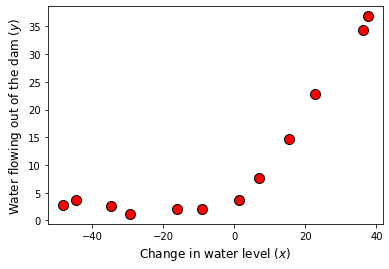

In [138]:
#load data from the matlabfile ex5data1.mat
data = loadmat(os.path.join('.', 'ex5data1.mat'))
print('Type data loaded from matlab file: ', type(data))
print('Keys of dict object loaded from matlab file: ', data.keys())

#extract training, cross validation and test data from object data
#then convert ground truth y's of 3 sets from 2-d to 1-d array
X, y = data['X'], data['y'] #training set
print('X.shape: %s, y.shape: %s'%(X.shape, y.shape))

Xval, yval = data['Xval'], data['yval'] #valudation set
print('X.shape: %s, y.shape: %s'%(Xval.shape, yval.shape))

Xtest, ytest = data['Xtest'], data['ytest']
print('X.shape: %s, y.shape: %s'%(Xtest.shape, ytest.shape)) #test set


#flatten out y's 
y = y.flatten()
yval = yval.flatten()
ytest = ytest.flatten()

#plot the training data
plt.scatter(X, y, marker='o', c='r', edgecolors='k', s=100)
plt.xlabel('Change in water level $(x)$', fontsize=12)
plt.ylabel('Water flowing out of the dam $(y)$', fontsize=12);

## 1.2 Regularize linear regression cost function

Recall that regularized linear regression has the following cost function:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overall cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that weshould not regularize
the $\theta_0$ term.

We should now complete the code in the function `linearRegCostFunction` in the next cell. Wer task is to calculate the regularized linear regression cost function. If possible, try to vectorize our code and avoid writing loops.
<a id="linearRegCostFunction"></a>

In [139]:
def linearRegCostFunction(theta, X, y, lambda_=0.0):
    '''
    Parameters
    ----------
    X : array_like
        The dataset. Matrix with shape (m x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    y : array_like
        The functions values at each datapoint. A vector of
        shape (m, ).
    
    theta : array_like
        The parameters for linear regression. A vector of shape (n+1,).
    
    lambda_ : float, optional
        The regularization parameter.
    
    Returns
    -------
    J : float
        The computed cost function. 
    
    grad : array_like
        The value of the cost function gradient w.r.t theta. 
        A vector of shape (n+1, ).
    '''
    
    #number of training examples
    m = y.size
    
    #initialize cost J
    J = 0
    grad = np.zeros(theta.shape)
    
    #add bias term to our training example
    #X = np.c_[np.ones((m, 1)), X]
    #cost
    J = 1 / (2 * m) * np.sum(np.square(X.dot(theta) - y)) + lambda_ / (2 * m) * (theta[1:] @ theta[1:])
    #gradients of cost function w.r.t theta
    grad = (1 / m) * (X.dot(theta) - y) @ X + (lambda_ / m) * np.r_[0, theta[1:]] 

    return J, grad

After having finished, we are gonna test our cost function at initialized `theta` = [1, 1].Expected cost should be 303.993 and `gradients` = [-15.303016, 598.250744].

In [140]:
theta = np.array([1.0, 1.0])
J, grad = linearRegCostFunction(theta, np.c_[np.ones(X.shape[0]), X], y)
print('Computed cost J: %.6f'%(J))
print('Exptected J: 303.993')
print('Gradient at theta = [1, 1]:  [{:.6f}, {:.6f}] '.format(*grad))
print(' (this value should be about [-15.303016, 598.250744])\n')

Computed cost J: 303.951526
Exptected J: 303.993
Gradient at theta = [1, 1]:  [-15.303016, 598.167411] 
 (this value should be about [-15.303016, 598.250744])



### Fitting linear regression model into the data

Next, we are going to create a function that fit the linear regression model using our defined function for cost and gradient computation. We will use the optimization module from scipy library to minimize the cost.

In [141]:
def regLinearRegression(costFunction, X, y, lambda_=0.0, maxiter=200):
    '''
    Train linear regression model given the defined cost function, training data X, actual output y, lambda_ and number of iterations
       Parameters
        ----------
        X : array_like
            The dataset with shape (m x n).

        y : array_like
            Function values at each datapoint. A vector of shape (m,).

        lambda_ : float, optional
            The regularization parameter.

        maxiter : int, optional
            Maximum number of iteration for the optimization algorithm.

        Returns
        -------
        J: float
           Cost function computed after training process finishes
        theta : array_like
           Trained paramter array
    '''

    #m, n
    m = y.size
    #initialize theta
    theta = np.zeros(X.shape[1])
    #minimizer object that contain the result from minimization 
    minimizer = optimize.minimize(costFunction, theta, args=(X, y, lambda_), method='TNC', jac=True, options={'maxiter':maxiter})
    
    return minimizer.fun, minimizer.x
    

Cost J:  22.373906495108905
Theta: [13.08790351  0.36777923]


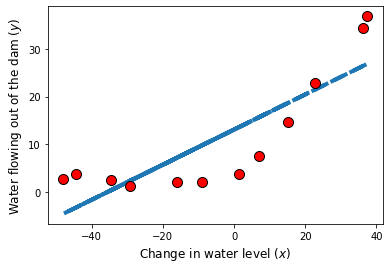

In [142]:
#final cost function and learn parameters
J, theta = regLinearRegression(linearRegCostFunction, np.concatenate([np.ones((X.shape[0], 1)), X], axis=1), y)
#add bias term to X
X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
print('Cost J: ', J)
print('Theta:', theta)
plt.plot(X, X_aug@theta, '--', lw=4)
plt.plot(X, y, 'ro', mec='k', ms=10)
plt.xlabel('Change in water level $(x)$', fontsize=12)
plt.ylabel('Water flowing out of the dam $(y)$', fontsize=12);

In [143]:
#fit the model using sklearn.Linear Regression

In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
linreg = LinearRegression()
linreg.fit(X, y)
print('Learned parameters:', linreg.intercept_, linreg.coef_.squeeze())
print('Mean square error:', mean_squared_error(y, linreg.predict(X)))

Learned parameters: 13.08790351086908 0.3677792297456508
Mean square error: 44.74781299021783


# 2 Bias - Variance

Bias - Variance tradeoff is an important concept in Machine Learning. Models with high bias will fail to learn from the data, so face underfitting. Not only that, models with high varaince will fail to generaize to new data, thus facing overfitting.

## 2.1 Learning Curve

We will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. Wer job is to fill in the function `learningCurve` in the next cell, so that it returns a vector of errors for the training set and cross validation set.


In [228]:
def learningCurve(X, y, Xval, yval, lambda_=0.0):
    """
    Generates the train and cross validation set errors needed to plot a learning curve
    returns the train and cross validation set errors for a learning curve. 
    
    In this function, you will compute the train and test errors for
    dataset sizes from 1 up to m. In practice, when working with larger
    datasets, you might want to do this in larger intervals.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).
    
    lambda_ : float, optional
        The regularization parameter.
    
    Returns
    -------
    error_train : array_like
        A vector of shape m. error_train[i] contains the training error for
        i examples.
    error_val : array_like
        A vecotr of shape m. error_val[i] contains the validation error for
        i training examples.

    """
    
    #number of training examples
    m = y.size
    #arrays of training and validation errors
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    #iterate over i from 1-m examples to fit the model then calculate the training/validation errors on i example
    for i in range(m):
        theta = regLinearRegression(linearRegCostFunction, X[:i+1, :], y[:i+1], lambda_=lambda_)[1]
        error_train[i] = linearRegCostFunction(theta, X[:i+1, :], y[:i+1], lambda_=0.0)[0]
        error_val[i] = linearRegCostFunction(theta, Xval, yval, lambda_=0.0)[0]
    return error_train, error_val

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	205.121096
  	2		0.000000	110.302641
  	3		3.286595	45.010231
  	4		2.842678	48.368910
  	5		13.154049	35.865165
  	6		19.443963	33.829961
  	7		20.098522	31.970986
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


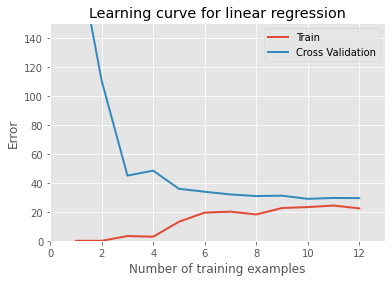

In [146]:
m = y.size
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
Xval_aug = np.concatenate([np.ones((yval.size, 1)), Xval], axis=1)
error_train, error_val = learningCurve(X_aug, y, Xval_aug, yval, lambda_=0)

plt.style.use('ggplot')
plt.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
# plt.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 150])


print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

# 3 Polynomial regression

The problem with our linear model was that it was too simple for the data
and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features. For polynomial regression, our hypothesis has the form:

$$
\begin{align}
h_\theta(x)  &= \theta_0 + \theta_1 \times (\text{waterLevel}) + \theta_2 \times (\text{waterLevel})^2 + \cdots + \theta_p \times (\text{waterLevel})^p \\
& = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
\end{align}
$$

Notice that by defining $x_1 = (\text{waterLevel})$, $x_2 = (\text{waterLevel})^2$ , $\cdots$, $x_p =
(\text{waterLevel})^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

Next, we are going to add more polynomial to our models for the purpose of increased complexity. This could be done through completion of the function `polyFeatures` in the next cell. The function is supposed to match the original training set $X$ of size $m$ to its higher powers. The expected output will be X of dimension $mxp$. We do not need to account for the 0-th power of this function.

In [147]:
#function to standardize the features input X, so that the mean value in each feature is 0 and the standard deviation is 1
def featureNormalize(X):
    """
    Normalizes the features in X returns a normalized version of X where the mean value of each
    feature is 0 and the standard deviation is 1. This is often a good preprocessing step to do when
    working with learning algorithms.

    Parameters
    ----------
    X : array_like
        An dataset which is a (m x n) matrix, where m is the number of examples,
        and n is the number of dimensions for each example.

    Returns
    -------
    X_norm : array_like
        The normalized input dataset.

    mu : array_like
        A vector of size n corresponding to the mean for each dimension across all examples.

    sigma : array_like
        A vector of size n corresponding to the standard deviations for each dimension across
        all examples.
    """
    #mean of X's features
    mu = np.mean(X, axis=0)
    #standard deviation of X's features
    sigma = np.std(X, axis=0, ddof=1)
    
    return (X - mu) / sigma, mu, sigma

In [148]:
def polyFeatures(X, p):
    """
    Maps X (1D vector) into the p-th power.
    
    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    
    p : int
        The polynomial power to map the features. 
    
    Returns 
    -------
    X_poly : array_like
        A matrix of shape (m x p) where p is the polynomial 
        power and m is the number of examples. That is:
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    """
    X_poly = np.zeros((X.shape[0], p))
    for i in range(p):
        X_poly[:, i] = X[:, 0] ** (i + 1)

    return X_poly

In [23]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)

print('Normalized Training Example 1:')
X_poly[0, :]

Normalized Training Example 1:


array([ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
        0.30661792, -0.59087767,  0.3445158 , -0.50848117])

In [24]:
#polynomial features using sklearn
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=8, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly.shape

(12, 8)

# 3.1 Learning Polynomial Regression


After having completed `polyFeatures`, we are moving onto training polynomial regression using the already-trained linear regression cost function for cost and gradients.

Due to the use of a polynomial function of degree 8, we need to preprocess the data by feature normalization due to different value range between our features, for example, (e.g., an example with $x = 40$ will now have a feature $x_8 = 40^8 = 6.5 \times 10^{12}$).


In [59]:
linreg.coef_

array([0.00000000e+00, 1.05358764e+01, 4.00692476e-01, 6.55122929e-03,
       1.81970403e-04, 3.36069737e-06, 8.19268269e-08, 1.59497667e-09,
       3.63334197e-11])

In [117]:
regLinearRegression??

Number of Example		Training Error		Validation Error
	1			0.000			138.847
	2			0.043			143.433
	3			2.515			6.945
	4			1.286			6.459
	5			1.028			6.473
	6			0.795			8.498
	7			1.410			5.792
	8			1.316			5.492
	9			1.459			6.430
	10			1.353			6.145
	11			1.229			6.206
	12			1.959			4.557


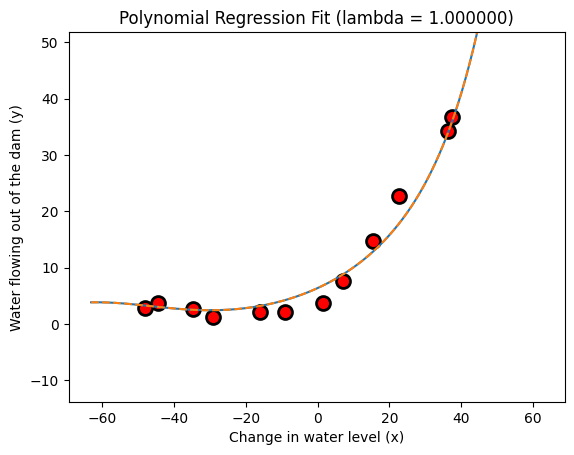

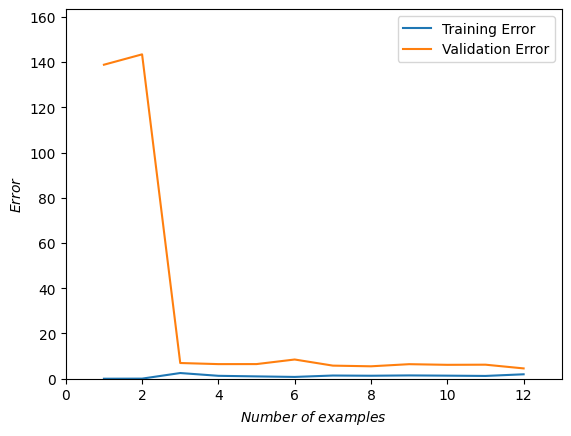

In [234]:
from sklearn.preprocessing import StandardScaler
p = 8
lambda_ = 1.0
#add polynomial features/terms for an 8th degree polynomial function
poly = PolynomialFeatures(degree=8, include_bias=False)
X_poly = poly.fit_transform(X)
# mu = np.mean(X_poly, axis=0) #mean of each feature
# sigma = np.std(X_poly, axis=0) #standard deviation of each feature
# X_poly = (X_poly - mu) / sigma #standardize the data before feeding into the polynomial function
standardizer = StandardScaler()
X_poly = standardizer.fit_transform(X_poly)
X_poly = np.concatenate([np.ones((X_poly.shape[0], 1)), X_poly], axis=1)

#learn parameter after preprocessing data
theta = regLinearRegression(linearRegCostFunction, X_poly, y, lambda_)[1]
#fit the 8-th degree polynomial model into the training for learning of parameter theta in minimization of cost
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1)
ridge.fit(X_poly[:, 1:], y)
#plot data
plt.style.use('default')
plt.plot(X, y, 'ro', ms=10, mec='k', mew=2)
x_min, x_max = X.min(), X.max()
plt.ylim([y.min()-15, y.max()+15])
x = np.arange(x_min - 15, x_max + 25, 0.05).reshape(-1, 1) #create a range of data points to plot the 8-th degree polynomial fit
x_poly = poly.fit_transform(x.reshape((-1, 1)))
# x_poly = (x_poly - mu) / sigma
x_poly = standardizer.transform(x_poly)
x_poly = np.concatenate([np.ones((x_poly.shape[0], 1)), x_poly], axis=1)
plt.plot(x, x_poly @ np.hstack([ridge.intercept_, ridge.coef_]))
plt.plot(x, x_poly @ theta, '--')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression Fit (lambda = %f)' % lambda_);


#plot training + val error
X_poly_val = poly.fit_transform(Xval) #add poly terms to validation set up to 8 order
X_poly_val = StandardScaler().fit_transform(X_poly_val)
X_poly_val = np.concatenate([np.ones((X_poly_val.shape[0], 1)), X_poly_val], axis=1)

error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_=1)
print('Number of Example\t\tTraining Error\t\tValidation Error')
for i in range(len(error_train)):
    print('\t%d\t\t\t%.3f\t\t\t%.3f'%(i+1, error_train[i], error_val[i]))
plt.figure()
plt.plot(range(1, m+1), error_train, label='Training Error')
plt.plot(range(1, m+1), error_val, label='Validation Error')
plt.legend(loc='upper right')
plt.xlabel('$Number$ $of$ $examples$')
plt.ylabel('$Error$')
plt.axis([0, 13, np.min([error_train, error_val]), np.max([error_train, error_val])+20]);

Based on the plot of our polynomial fit togerther with the plot of the learning curve for number of examples, we can see that our model suffers from overfitting, meaning the training error stays unchanged at 0 over all the number of examples. However, the validation error is very high and unstable with fluctiations. This is an indicator for the problem of overfitting. 

One of the technique to reduce overfitting is to use L1 or L2 regularization by adding an regularization term with parameter Lambda. This is expected for a good effect on bias-variance tradeoffs of our our model. 

We are, therefore, applying an automated method to select the optimum $\lambda$ value given a set of values. More concretely, we will fit the polynomial function to the training data for learn parameters. After that, cross-validation set is used to evaluate the good value of regularization parameter $\lambda$. Finally, test set is used for evaluation of generalization on data by our model or saying, how well our model could work with actual unseen data.

In [242]:
def validationCurve(X, y, Xval, yval, lambda_vec=[0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]):
    """
    Generate the train and validation errors needed to plot a validation
    curve that we can use to select lambda_.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n) where m is the 
        total number of training examples, and n is the number of features 
        including any polynomial features.
    
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n) where m is the 
        total number of validation examples, and n is the number of features 
        including any polynomial features.
    
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).
    
    Returns
    -------
    lambda_vec : list
        The values of the regularization parameters which were used in 
        cross validation.
    
    error_train : list
        The training error computed at each value for the regularization
        parameter.
    
    error_val : list
        The validation error computed at each value for the regularization
        parameter.
    
    """
    error_train = []
    error_val = []
    
    for i in lambda_vec:
        theta = regLinearRegression(linearRegCostFunction, X, y,lambda_=i, maxiter=55)[1]
        error_train.append(linearRegCostFunction(theta, X, y, lambda_=0.0)[0])
        error_val.append(linearRegCostFunction(theta, Xval, yval, lambda_=0.0)[0])
        
    return error_train, error_val

After having completed the function above, we are going to make a plot between the given values of lambda against the training and validation error. This method is supposed to help us choose the best lambda value for "just-right" trade-off between variance and bias.

In [243]:
X_poly.shape

(12, 9)

Lambda		Training Error		Validation Error
0.000000	0.068101		7.876899
0.001000	0.112736		10.629805
0.003000	0.180522		17.386559
0.010000	0.218195		15.379753
0.030000	0.274574		12.257079
0.100000	0.438653		8.149981
0.300000	0.868144		5.378058
1.000000	1.958691		4.556537
3.000000	4.525119		4.998845
10.000000	14.825808		12.436982


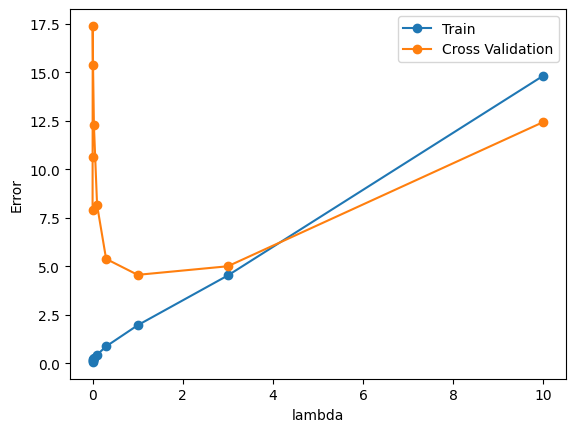

In [259]:
#test the function
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval, lambda_vec=lambda_vec)
plt.plot(lambda_vec, error_train, '-o',   lambda_vec, error_val, '-o')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('lambda')
plt.ylabel('Error')
print('Lambda\t\tTraining Error\t\tValidation Error')
for i in range(len(lambda_vec)):
    print('%f\t%f\t\t%f'%(lambda_vec[i], error_train[i], error_val[i]))